In [50]:
import numpy as np
import matplotlib.pyplot as plt

def interpolated_peak(x, y, order=2, dx=0.01):
    """
    Interpolate the peak of a dataset (x, y) using polynomial fitting.
    
    Parameters:
        x (array): x-values (e.g. lags)
        y (array): y-values (e.g. cross-correlation)
        order (int): polynomial order
        dx (float): resolution of interpolation grid
    
    Returns:
        float: x-value at interpolated peak
    """
    x_fit = np.arange(min(x), max(x), dx)
    coeffs = np.polyfit(x, y, order)
    y_fit = np.polyval(coeffs, x_fit)
    peak_index = np.argmax(y_fit)
    return x_fit[peak_index]


In [65]:
from scipy.ndimage import uniform_filter1d
from scipy.signal import correlate, correlation_lags


def correlation_velocity(data, r1, r2, L, order=2, time_scale=100,
                          detrend=False, interpolated=False,
                          timeCadence=300.0, pixelSize=9744.0):
    """
    Calculate cross-correlation-based velocity from a distance-time data cube.

    Parameters:
        data (ndarray): 3D array [angles, time, radius]
        r1, r2 (int): radial indices to compare
        L (int): window length for lag
        order (int): interpolation order (e.g., 2 for quadratic)
        time_scale (float): smoothing scale for detrending
        detrend (bool): if True, subtracts smoothed background
        interpolated (bool): if True, interpolates correlation peak
        timeCadence (float): time cadence in seconds
        pixelSize (float): spatial scale in km/pixel

    Returns:
        velocity (np.ndarray): estimated velocity at each angle
    """
    nangles = data.shape[2] if data.ndim == 3 else 1
    velocity = np.zeros(nangles)
    lags = np.arange(-L//2, L//2 + 1)

    for x in range(nangles):
        if data.ndim == 3:
            profile1 = data[r1 * 71, :, x]
            profile2 = data[r2 * 71, :, x]
        else:
            profile1 = data[r1 * 71, :]
            profile2 = data[r2 * 71, :]

        if detrend:
            profile1 -= uniform_filter1d(profile1, size=int(time_scale), mode='nearest')
            profile2 -= uniform_filter1d(profile2, size=int(time_scale), mode='nearest')

        # Cross-correlation using scipy.signal.correlate
        cc = np.correlate(profile2, profile1, mode='full')
        lags = correlation_lags(len(profile2), len(profile1), mode='full')
        # Find the lag with the maximum correlation
        max_corr_lag = lags[np.argmax(cc)]
        i_peak = np.argmax(cc)
        peak_lag = lags[i_peak]

        if interpolated and 2 <= i_peak <= len(cc) - 3:
            x_vals = lags[i_peak-2:i_peak+3]
            y_vals = cc[i_peak-2:i_peak+3]
            peak_lag = interpolated_peak(x_vals, y_vals, order=order)
        else:
            lag_value = peak_lag

        delta_r = (r2 - r1) * 71.0  # pixel separation
        velocity[x] = (delta_r * pixelSize) / (peak_lag * timeCadence)

    return velocity


In [68]:
data = np.load("processed_data.npy")

data.shape

(659, 848, 3600)

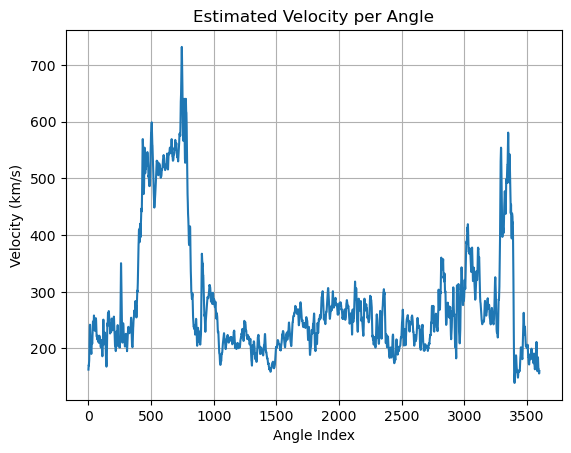

In [75]:
# Run cross-correlation based velocity measurement
velocities = correlation_velocity(data, r1=2, r2=3, L=50, interpolated=True, detrend=True)


# Plot result
plt.plot(velocities)
plt.title('Estimated Velocity per Angle')
plt.xlabel('Angle Index')
plt.ylabel('Velocity (km/s)')
plt.grid(True)
plt.show()